In [94]:
import numpy as np

In [95]:
dia_hebra = 0.27 # mm
# 
F_hebra = 3.241 # kg
F_hebra_kg = F_hebra
F_hebra = 9.81*F_hebra # N
A_hebra = np.pi*(dia_hebra/2)**2
sigma_hebra = F_hebra/A_hebra # MPa

F_trenzado = 172.667 # kg
F_trenzado_kg = F_trenzado
F_trenzado = 9.81*F_trenzado # N
dia_trenzado = 4 # mm

# 4 monofilamentos x 16 + 15 monofilamentos en alma
theta = 85 # grados
ctheta = np.sin(np.deg2rad(theta))
Nalma = 15
Atrenzado = (ctheta*16*4 + Nalma)*np.pi*(dia_hebra/2)**2 
sigma_trenzado = F_trenzado/Atrenzado # MPa

# homogenized 
Atrenzado_homogenized = np.pi*(dia_trenzado/2)**2
sigma_trenzado_homogenized = F_trenzado/Atrenzado_homogenized # MPa
# print with 2 decimals
print(f"sigma_trenzado = {sigma_trenzado:.2f} MPa")
print(f"sigma_hebra = {sigma_hebra:.2f} MPa")
print(f"sigma_trenzado_homogenized = {sigma_trenzado_homogenized:.2f} MPa")
# 
# ratio 
ratio = sigma_trenzado/sigma_hebra
print(f"ratio = {ratio:.3f}")

sigma_trenzado = 375.64 MPa
sigma_hebra = 555.30 MPa
sigma_trenzado_homogenized = 134.79 MPa
ratio = 0.676


In [96]:
from tools.step.runstep import runstep,address,lj
import os


In [97]:
import glob

In [98]:
files = glob.glob('output/*.json')

In [99]:
file = files[-1]

In [100]:
id_sim = os.path.basename(file).replace('.json','')

In [101]:
id_sim


'2024-09-16__11-26-28__20673'

In [102]:
params_sim = lj(id_sim)
params = lj(params_sim["dependencies"]["post_path"])

In [103]:
from matplotlib import pyplot as plt
import numpy as np

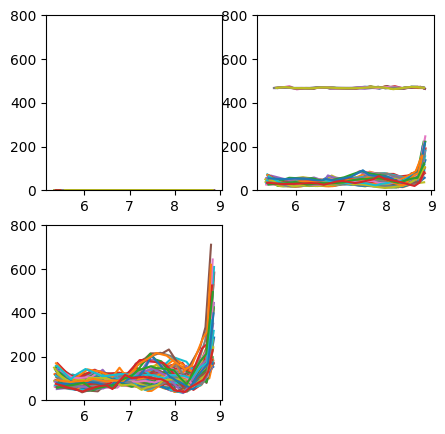

In [104]:

nms = len(params["results"]["measurements"])
nnsqrt_plots = np.ceil(np.sqrt(nms))
# int 
nnsqrt_plots = int(nnsqrt_plots)
fig = plt.figure(figsize=(5, 5))


for i in range(nms):
    plt.subplot(nnsqrt_plots, nnsqrt_plots, i+1)
    mt = params["results"]["measurements"][i]["mt"]
    mt_z = params["results"]["measurements"][i]["mt_z"]
    for imt,imt_z in zip(mt,mt_z):
        plt.plot(imt_z, imt)

    plt.ylim(0,800)

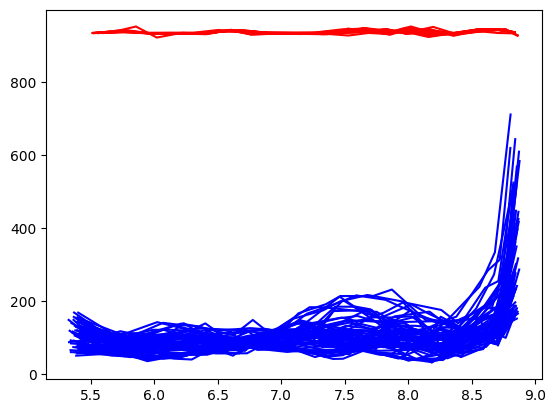

In [105]:
iter = 0
for imt,imt_z in zip(mt,mt_z):
    if iter > 63:
        color = 'red'
    else:
        color = 'blue'
    plt.plot(imt_z, imt, color=color)
    iter += 1

In [107]:
steps = params["results"]["frd"]["steps"]
step_str =  [ i[:7 ] for i in steps ]
step_str = np.array(step_str)    
step_str_uq = np.unique(step_str)

indx = [ np.where(step_str == iuq )[-1][-1] for iuq in step_str_uq]


sigma_max = [i["sigma_max"] for i in params["results"]["measurements"]]
epsilon = [i["epsilon"] for i in params["results"]["measurements"]]
Ftotal = [i["F_total"] for i in params["results"]["measurements"]]

sigma_max = np.array(sigma_max)
sigma_max = sigma_max[indx]
epsilon = np.array(epsilon)
epsilon = epsilon[indx]
Ftotal = np.array(Ftotal)/9.81 # kg
Ftotal = Ftotal[indx]

step_str_uq = step_str[indx]

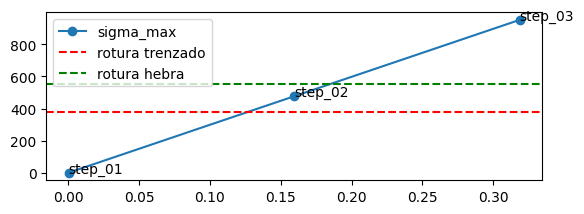

In [109]:
plt.subplot(2,1,1)

plt.plot(epsilon,sigma_max,label="sigma_max",marker="o")

#  MPa rotura trenzado 
# horizontal line
plt.axhline(y=sigma_trenzado, color='r', linestyle='--',label="rotura trenzado")
# MPa rotura hebra
plt.axhline(y=sigma_hebra, color='g', linestyle='--',label="rotura hebra")
for i,isteps in enumerate(step_str_uq):
    plt.text(epsilon[i], sigma_max[i], str(isteps))
plt.legend()





In [110]:
F_trenzado_kg

172.667

In [111]:
Ftotal

array([8.10166337e-02, 4.47850605e+01, 9.69096219e+01])

In [112]:
angle = 70
ctheta = np.sin(np.deg2rad(angle))
Ftotal_correrted = Ftotal*((64*ctheta+Nalma)/64*ctheta)

In [113]:
Ftotal_correrted

array([8.93826284e-02, 4.94096859e+01, 1.06916769e+02])

In [114]:
((64*ctheta+Nalma)/64*ctheta)

1.1032626795561862

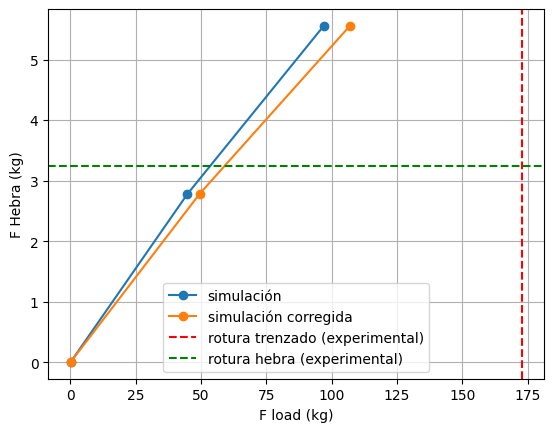

In [116]:
# linear regression

Fmax =  sigma_max*A_hebra/9.81
plt.plot(Ftotal,Fmax,label="simulación",marker="o")

plt.plot(Ftotal_correrted,Fmax,label="simulación corregida",marker="o")
#horizontal line
plt.axvline(x=F_trenzado_kg, color='r', linestyle='--',label="rotura trenzado (experimental)")
#homogenized
# plt.axvline(x=sigma_trenzado_homogenized, color='b', linestyle='--',label="rotura trenzado (homogenized)")
#horizontal line
plt.axhline(y=F_hebra_kg, color='g', linestyle='--',label="rotura hebra (experimental)")
#
plt.ylabel("F Hebra (kg)")
plt.xlabel("F load (kg)")
plt.grid()
plt.legend()

In [215]:
csv_file = "./data.csv"

import pandas as pd

df = pd.read_csv(csv_file)

df1 = df.iloc[:,0:2]
df2 = df.iloc[:,2:4]
df3 = df.iloc[:,4:6]

dfs = [df1,df2,df3]

# Change the column names 1-> Displacement, 2-> Force
#remove  nan values and 1st row
# set number type 
df_new = []
cursor = [1.1,195]

for df in dfs:
    df.columns = ["Displacement","Force"]
    df = df.dropna()
    df = df.drop([0,1])
    df["Displacement"] = df["Displacement"].astype(float)
    df["Force"] = df["Force"].astype(float)
    df["Displacement"] = df["Displacement"] - cursor[0]
    df["Force"] = df["Force"] - cursor[1]
    # add cero cero
    df = pd.concat([pd.DataFrame([[0,0]],columns=["Displacement","Force"]),df],ignore_index=True)
    df_new.append(df)

In [216]:
df["Displacement"]

0      0.000000
1      1.905060
2      3.068938
3      3.846102
4      4.860526
5      5.966863
6      7.159511
7      8.258003
8      9.450651
9     10.566578
10    11.752252
11    12.903052
12    14.127086
13    15.319733
14    16.533305
15    17.715491
16    18.897677
17    20.017092
18    21.133020
19    22.330317
20    23.479956
21    24.608670
22    25.771095
23    26.887023
24    28.041311
25    29.223497
26    30.405683
27    31.525098
28    32.641026
29    33.826699
30    34.977499
31    36.116676
32    37.258177
33    38.377592
34    39.549316
35    40.741964
36    41.870679
37    43.033103
38    44.131595
39    45.334705
40    46.495967
41    47.667691
42    48.787106
43    49.958831
44    51.088707
45    52.239508
46    53.390309
47    54.541109
48    55.691910
49    56.842710
50    57.993511
51    59.144311
52    60.295112
53    61.445913
54    62.596713
55    63.747514
56    64.427532
Name: Displacement, dtype: float64

In [224]:
def intergrate(df,eps1):

    # find the index of the first element that is greater than eps1
    indx = df["Displacement"].searchsorted(eps1)[0]
    # get the values of the previous element
    
    return np.trapz(df["Force"].values[:indx],df["Displacement"].values[:indx])

def theta(x,eta):
    return np.arctan(eta*x)
def error(df,eps1,eps,Fmax,slope):

    integral = intergrate(df,eps1)

    F =  -integral  + eps1**2*slope/2 - Fmax*(eps-eps1)
    return F**2
    

eps1 = [43.16914424]
error = [6.86196651e-10]
F_eq = [2956.86607833]


KeyError: 'eq'

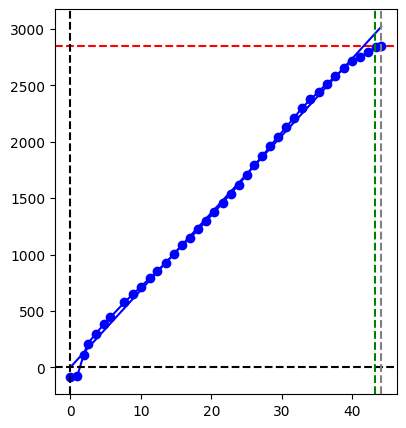

In [232]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
## optimize with constraints
from scipy.optimize import minimize

fig = plt.figure(figsize=(15,5))
colors = ["blue","red","green"]
for i,df in enumerate(df_new):
    plt.subplot(1,3,i+1)
    D_span = np.linspace(0,df["Displacement"].max(),100)
    ##linear regression
    nlen = len(df["Displacement"])
    nlen = int(nlen/2)
    slope, intercept, r_value, p_value, std_err = linregress(df["Displacement"][:nlen],
                                                             df["Force"][:nlen])


    # Correct the intercept 
    df["Force"] = df["Force"] - intercept


    Fmax = df["Force"].max()
    eps   = df["Displacement"].max()

    error_f = lambda eps1: error(df,eps1,eps,Fmax,slope)

    ## optimize 
    eps_0 = eps
    limits = [eps/2,eps]
    res = minimize(error_f,eps_0,method='L-BFGS-B',bounds=[limits])
    eps1 = res.x
    
    print(f"eps1 = {eps1}")
    print(f"error = {error_f(eps1)}")
    plt.axhline(y=Fmax, color='r', linestyle='--',label="Fmax")
    plt.plot(df["Displacement"],df["Force"],marker="o",color=colors[i],label=f"exp {i+1}")

    A = np.trapz(df["Force"],df["Displacement"]) 
    plt.plot(D_span, D_span*slope ,label=f"exp {i+1}",color=colors[i])
    # plot xaxis and yaxis
    plt.axhline(y=0, color='k', linestyle='--')
    plt.axvline(x=0, color='k', linestyle='--')

    plt.axvline(x=eps, color='gray', linestyle='--',label=r"$\epsilon = {:.2f}$".format(eps))
    plt.axvline(x=eps1, color='g', linestyle='--',label=r"$\epsilon_1 = {:.2f}$".format(eps1[0]))

    Feq = eps1*slope
    print(f"F_eq = {Feq}")
    plt.axhline(y=Feq, color='g', linestyle='--',label=r"$F_{eq} = {:.2f}$".format(Feq))
    plt.legend()
    plt.grid()

In [219]:
intercept

37.174783010804276